In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

In [143]:
# Functions adapted from https://github.com/transientskp/tkp/blob/master/tkp/utility/sigmaclip.py

def clip(data, mean, sigma):
    """Performs sigma clipping of data around mean.
    
    Parameters
    ----------
    data numpy.ndarray: 
        Array of values.
    mean: float
        Value around which to clip (does not have to be the mean).
    sigma: float
        Sigma-value for clipping.
        
    Returns
    -------
    indices: numpy.ndarray
        Indices of non-clipped data.
    """
    ilow = data >= mean - sigma
    ihigh = data <= mean + sigma
    indices = np.logical_and(ilow, ihigh)
    
    return indices


def calc_sigma(data, errors=None):
    """Calculates the weighted standard deviation.
    
    Parameters
    ----------
    data: numpy.ndarray
        Data to be averaged.
    errors: numpy.ndarray, default 'None'
        Errors for the data. If 'None', unweighted
        values are calculated.
        
    Returns
    -------
    wmean: numpy.ndarray
        Weighted mean.
    wsigma: numpy.ndarray
        Weighted standard deviation.
    """
    if errors is None:
        w = 1.0
    else:
        w = 1.0/errors**2
        wmean = np.average(data, weights=w)
    
    V1 = w.sum()
    V2 = (w**2).sum()
    # weighted sample variance
    wsigma = np.sqrt(((data - wmean) * (data - wmean)*w).sum() *
                        (V1 / (V1*V1 - V2)))

    return wmean, wsigma


def weighted_sigmaclip(data, errors=None, niter=0, n_sigma=3, 
                       use_median=False):
    """Remove outliers from data which lie more than n_sigma
    standard deviations from mean.
    
    Parameters
    ----------
    data: numpy.ndarray
        Array containing data values.
    errors: numpy.ndarray, default 'None'
        Errors associated with the data. If 'None', unweighted mean 
        and standard deviation are used in calculations.
    niter: int, default '0' 
        Number of iterations to calculate mean and standard
        deviation, and reject outliers, If niter is negative,
        iterations will continue until no more clipping occurs or
        until abs('niter') is reached, whichever is reached first.
    n_sigma: float, default '3' 
        Number of standard deviations used for sigma clipping.
    use_median: bool, default 'False':
        If 'True', use median of data instead of mean.
        
    Returns
    -------
    indices: boolan numpy.array
        Boolean numpy array of indices indicating which
        elements are clipped (False), with the same shape as the
        input
    i: int
        Number of iterations
    """
    # indices keeps track which data should be discarded
    indices = np.ones(len(data.ravel()), 
                         dtype=np.bool).reshape(data.shape)
    
    if niter < 0:
        nniter = -niter
    else:
        nniter = niter
    
    for i in range(nniter):
        newdata = data[indices]
        if errors is None:
            newerrors = None
        else:
            newerrors = errors[indices]
        
        N = len(newdata)
        if N < 2:
            # no data left to clip
            return indices, i

        mean, sigma = calc_sigma(newdata, newerrors)
        if use_median:
            mean = np.median(newdata)
        newindices = clip(data, mean, n_sigma*sigma)
        
        if niter < 0:
            # break when no changes
            if (newindices == indices).all():
                break
        indices = newindices
        
    return indices, i + 1

In [144]:
def weighted_rolling(x_data, y_data, yerr_data, window, center=False):
    """Weighted rolling functions, similar to pandas
    rolling function.
    
    Parameters
    ----------
    x_data: array
        X-axis data.
    y_data: array
        Y-axis data.
    yerr_data: array
        Y-axis error.
    window: float
        Time window in the same units as 'x'.
    center: bool, default 'False'
        If 'False', set the window labels as the right 
        edge of the window index. If 'True', set the window 
        labels as the center of the window index.

        
    Returns
    -------
    rolling_y: array
        Rolling data.
    """
    rolling_dict = {'x':[], 'y':[], 'yerr':[]}
    
    for i, x in enumerate(x_data):
        if center==True:
            roll_x = x_data.copy() 
            roll_y = y_data.copy()[mask]
            roll_yerr = yerr_data.copy()[mask]
            mask = np.abs(x-roll_x)<=window/2
        else:
            roll_x = x_data[:i+1].copy()
            roll_y = y_data[:i+1].copy()
            roll_yerr = yerr_data[:i+1].copy()
            mask = x-roll_x<=window
            
        roll_x = roll_x[mask]
        roll_y = roll_y[mask]
        roll_yerr = roll_yerr[mask]
        
        # x-axis
        rolling_dict['x'].append(roll_x.mean())
        # y-axis
        w = 1/roll_yerr**2
        wmean = np.average(roll_y, weights=w)
        rolling_dict['y'].append(wmean)
        # y-error: weighted sample variance
        wvar = np.sum(w * (roll_y - wmean)**2) / np.sum(w)
        wstd = np.sqrt(wvar)
        rolling_dict['yerr'].append(wstd)
        
    # turn lists into arrays    
    for key, values in rolling_dict.items():
        rolling_dict[key] = np.array(rolling_dict[key])
    
    return rolling_dict['x'], rolling_dict['y'], rolling_dict['yerr']

In [149]:
class lightcurve(object):
    """Light curve class.
    """
    def __init__(self, band, lcs_df):
        self.band = band

        data = lcs_df[lcs_df.F == band]
        self.time = data.MJD.values
        self.mag = data.m.values
        self.mag_err = data.dm.values
        color_dict = {'c':'cyan', 'o':'orange'}
        self.color = color_dict[band]

    def __repr__(self):
        return f'band: {self.band}'

    def __getitem__(self, item):
        return getattr(self, item)
        
    def sigma_clip(self, niter=0, n_sigma=3, use_median=False):
        
        indices, iter_val = weighted_sigmaclip(self.mag, self.mag_err, 
                                             niter, n_sigma, use_median)
        self.time = self.time[indices]
        self.mag = self.mag[indices]
        self.mag_err = self.mag_err[indices]
        self.iter = iter_val
        
    def rolling(self, window, center=False):
        
        x, y, yerr = weighted_rolling(self.time, self.mag, 
                                     self.mag_err, window, center)
        self.time = x
        self.mag = y
        self.mag_err = yerr

class lightcurves(object):
    """Multi-colour light curves class.
    """
    def __init__(self, lcs_df):
        self.bands = lcs_df.F.unique()

        for band in self.bands:
            lc = lightcurve(band, lcs_df)
            setattr(self, band, lc)

    def __repr__(self):
        return str(self.bands)

    def __getitem__(self, item):
        return getattr(self, item)

In [150]:
class atlas_object(object):
    
    def __init__(self, lc_file):
        self.lc_file = lc_file
        lc_df = pd.read_csv(lc_file)
        self.lc_df = lc_df
        self.lcs = lightcurves(lc_df)
        self.init_lcs = deepcopy(self.lcs)
        self.bands = lc_df.F.unique()
        self.modified = False
        
    def __repr__(self):
        rep = (f'LC file: {self.lc_file}')
        return rep
    
    def __getitem__(self, item):
        return getattr(self, item)
    
    def plot_original(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        for filt in self.bands:
            init_lcs = self.init_lcs[filt]
            ax.errorbar(init_lcs.time, init_lcs.mag, init_lcs.mag_err, 
                        fmt='o', label=filt, c=init_lcs.color, mec='k')

        ax.set_ylabel('Appartent Magnitude', fontsize=18)
        ax.set_xlabel('MJD', fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_ylim(15, 25)
        ax.set_xlim(58630, 58750)
        ax.invert_yaxis()
        ax.legend(fontsize=18)
        plt.show()
        
    def plot_lcs(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        for filt in self.bands:
            if self.modified:
                lcs = self.lcs[filt]
                ax.errorbar(lcs.time, lcs.mag, lcs.mag_err, 
                        fmt='*', c=lcs.color)
                alpha = 0.2
            else:
                alpha = 1
            
            init_lcs = self.init_lcs[filt]
            ax.errorbar(init_lcs.time, init_lcs.mag, init_lcs.mag_err, 
                        fmt='o', label=filt, c=init_lcs.color, mec='k',
                        alpha=alpha)

        ax.set_ylabel('Appartent Magnitude', fontsize=18)
        ax.set_xlabel('MJD', fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_ylim(15, 25)
        ax.set_xlim(58630, 58750)
        ax.invert_yaxis()
        ax.legend(fontsize=18)
        plt.show()
        
    def rolling(self, window, center=False):
        color_dict = {'c':'blue', 'o':'red'}
        for filt in self.bands:
            self.lcs[filt].rolling(window, center)
            self.lcs[filt].color = color_dict[filt]
        self.modified = True
            
    def sigma_clip(self, niter=0, n_sigma=3, use_median=False):
        color_dict = {'c':'blue', 'o':'red'}
        for filt in self.bands:
            self.lcs[filt].sigma_clip(niter, n_sigma, use_median)
            self.lcs[filt].color = color_dict[filt]
        self.modified = True

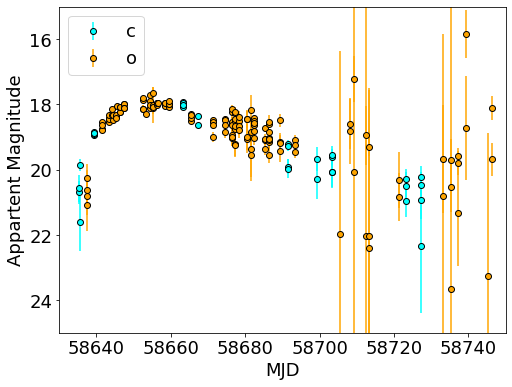

In [151]:
lc_file = 'test_lc.csv'
obj = atlas_object(lc_file)
obj.plot_lcs()

/tmp/ipykernel_8949/1087445318.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool).reshape(data.shape)


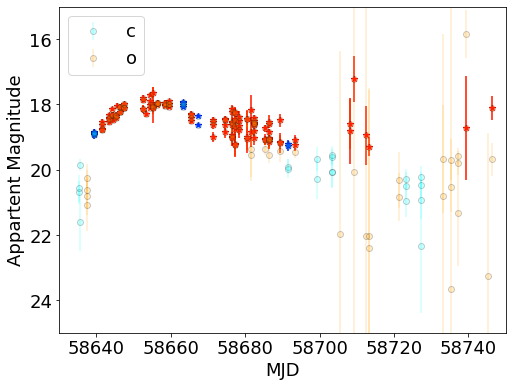

In [152]:
#obj.rolling(10)
obj.sigma_clip(3)
obj.plot_lcs()